# Cancer Cell Detection:
## Advanced Machine Learning and Neural Networks - MET CS 767 - Final Project

by David Garcia

## Import and download necessary libraries

In [ ]:
pip install -q pydicom

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 24.0 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Data Loading and Preprocessing
import os
import pydicom
import numpy as np
import pandas as pd
import cv2
import pickle
from xml.etree import ElementTree
from sklearn.model_selection import train_test_split

# Data Visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from google.colab.patches import cv2_imshow
import seaborn as sns

# Model Building and Training
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import load_model
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

## Data Exploration
- Display scans
- View format and size of scans
- Retrieve annotations
- Analyze data
- Store data in Google Drive

### General Data

In [ ]:
# Define the directory path
base_dir = '/content/drive/MyDrive/METCS767/Final Project: Cancer Detection/Lung-PET-CT-Dx'

# Initialize a variable to store the total count of directories in the base directory
total_folders = 0

# List all items in the base directory and sort them alphabetically
for folder_name in sorted(os.listdir(base_dir)):
    folder_path = os.path.join(base_dir, folder_name)

    # Check if the item is a directory
    if os.path.isdir(folder_path):
        total_folders += 1

# Print the total number of folders in the base directory
print(f"Total number of folders in the base directory: {total_folders}.\nEach folder represents one different subject.")

Total number of folders in the base directory: 355.
Each folder represents one different subject.


In [ ]:
# Sample file paths
sample_a = '/content/drive/MyDrive/METCS767/Final Project: Cancer Detection/Lung-PET-CT-Dx/Lung_Dx-A0002/04-25-2007-NA-ThoraxAThoraxRoutine Adult-34834/2.000000-ThoraxRoutine  8.0.0  B70f-62919/1-01.dcm'
sample_g = '/content/drive/MyDrive/METCS767/Final Project: Cancer Detection/Lung-PET-CT-Dx/Lung_Dx-G0060/01-21-2011-NA-PET01PTheadlung Adult-07418/10.000000-Thorax  1.0  B70f-17914/1-001.dcm'

# Load and read DICOM file
dicom_data = pydicom.dcmread(sample_a)
pixel_array = dicom_data.pixel_array
print(f"Shape of the image: {pixel_array.shape}")

Shape of the image: (512, 512)


### Display Scans

                   A - Adenocarcinoma


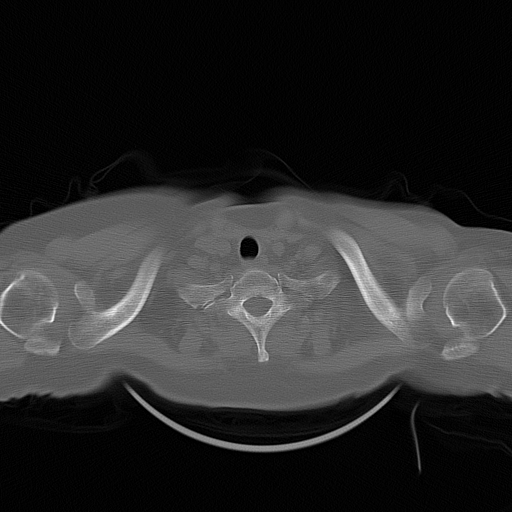


                   G - Squamous Cell Carcinoma


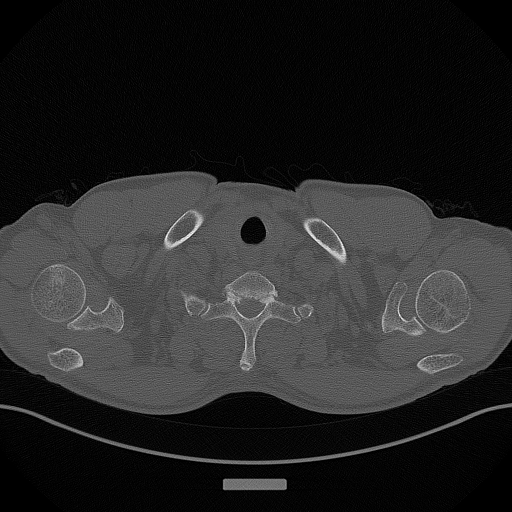

In [ ]:
# Dictionary of samples
samples_list = {
    "A - Adenocarcinoma": sample_a,
    "G - Squamous Cell Carcinoma": sample_g,
}

# Display each DICOM file
for label, sample in samples_list.items():
    # Read the DICOM file
    dicom_data = pydicom.dcmread(sample)

    # Extract pixel data
    pixel_array = dicom_data.pixel_array

    # Normalize pixel values to [0, 255] for visualization
    normalized_image = cv2.normalize(pixel_array, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    # Display the image
    print(f"                   {label}")
    cv2_imshow(normalized_image)
    print()

### Metadata

In [ ]:
# View metadata
print(dicom_data)

Dataset.file_meta -------------------------------
(0002,0000) File Meta Information Group Length  UL: 206
(0002,0001) File Meta Information Version       OB: b'\x00\x01'
(0002,0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002,0003) Media Storage SOP Instance UID      UI: 1.3.6.1.4.1.14519.5.2.1.6655.2359.265628284715084417645332581911
(0002,0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002,0012) Implementation Class UID            UI: 1.3.6.1.4.1.22213.1.143
(0002,0013) Implementation Version Name         SH: '0.5'
(0002,0016) Source Application Entity Title     AE: 'POSDA'
-------------------------------------------------
(0008,0005) Specific Character Set              CS: 'ISO_IR 100'
(0008,0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL', 'CT_SOM5 SPI']
(0008,0016) SOP Class UID                       UI: CT Image Storage
(0008,0018) SOP Instance UID                    UI: 1.3.6.1.4.1.14519.5.2.1.6655.2359.26

### Obtain XML Annotations

#### Function

In [ ]:
def get_category(category_file):
    class_list = []
    with open(category_file, 'r') as f:
        for line in f.readlines():
            class_list.append(line.rstrip('\n'))

    return class_list

class XML_preprocessor(object):

    def __init__(self, data_path, num_classes, normalize=False):
        self.path_prefix = data_path
        self.num_classes = num_classes
        self.normalization = normalize
        self.data = dict()
        self._preprocess_XML()

    def _preprocess_XML(self):
        filenames = os.listdir(self.path_prefix)
        for filename in filenames:
            tree = ElementTree.parse(os.path.join(self.path_prefix, filename))
            root = tree.getroot()
            bounding_boxes = []
            one_hot_classes = []
            size_tree = root.find('size')
            width = float(size_tree.find('width').text)
            height = float(size_tree.find('height').text)
            for object_tree in root.findall('object'):
                for bounding_box in object_tree.iter('bndbox'):
                    if self.normalization:
                        xmin = float(bounding_box.find('xmin').text)/width
                        ymin = float(bounding_box.find('ymin').text)/height
                        xmax = float(bounding_box.find('xmax').text)/width
                        ymax = float(bounding_box.find('ymax').text)/height
                    else:
                        xmin = float(bounding_box.find('xmin').text)
                        ymin = float(bounding_box.find('ymin').text)
                        xmax = float(bounding_box.find('xmax').text)
                        ymax = float(bounding_box.find('ymax').text)
                bounding_box = [xmin,ymin,xmax,ymax]
                bounding_boxes.append(bounding_box)
                class_name = object_tree.find('name').text
                one_hot_class = self._to_one_hot(class_name)
                one_hot_classes.append(one_hot_class)
            # image_name = root.find('filename').text
            image_name = filename
            bounding_boxes = np.asarray(bounding_boxes)
            one_hot_classes = np.asarray(one_hot_classes)
            image_data = np.hstack((bounding_boxes, one_hot_classes))
            self.data[image_name] = image_data

    def _to_one_hot(self, name):
        one_hot_vector = [0] * self.num_classes  # This will now have 3 classes instead of 4 (A, B, G)
        name = name.lower()  # Convert to lowercase to handle both 'A' and 'a'

        # Check if the label is one of the predefined classes
        if name == 'a':
            one_hot_vector[0] = 1  # Class A is at index 0
        elif name == 'g':
            one_hot_vector[1] = 1  # Class G is now at index 2 (previously index 3)
        else:
            # Skip processing for classes B and E
            pass

        return one_hot_vector

#### Sample

In [ ]:
# Define the directory path containing the XML files
sample_a = '/content/drive/MyDrive/METCS767/Final Project: Cancer Detection/Annotation/A0001/'

# Initialize the XML_preprocessor with the directory and number of classes
num_classes = 2
data_test = XML_preprocessor(sample_xml_directory, num_classes).data

In [ ]:
data_test

{'1.3.6.1.4.1.14519.5.2.1.6655.2359.289186849349654450104973032531.xml': array([[293., 318., 348., 384.,   1.,   0.]]),
 '1.3.6.1.4.1.14519.5.2.1.6655.2359.253763111879303517159545374933.xml': array([[289., 317., 353., 391.,   1.,   0.]]),
 '1.3.6.1.4.1.14519.5.2.1.6655.2359.136943255924913899762603730997.xml': array([[278., 308., 360., 394.,   1.,   0.]]),
 '1.3.6.1.4.1.14519.5.2.1.6655.2359.218387194706247505045205169130.xml': array([[287., 315., 355., 387.,   1.,   0.]]),
 '1.3.6.1.4.1.14519.5.2.1.6655.2359.301905642463494729146015070819.xml': array([[282., 307., 355., 388.,   1.,   0.]]),
 '1.3.6.1.4.1.14519.5.2.1.6655.2359.216515627058008697217695696166.xml': array([[288., 313., 351., 380.,   1.,   0.]]),
 '1.3.6.1.4.1.14519.5.2.1.6655.2359.187586942311847648079258238193.xml': array([[287., 300., 342., 379.,   1.,   0.]]),
 '1.3.6.1.4.1.14519.5.2.1.6655.2359.326712390675165848304281961959.xml': array([[287., 313., 349., 385.,   1.,   0.]]),
 '1.3.6.1.4.1.14519.5.2.1.6655.2359.5924

In [ ]:
# key: diemensions
data_test['1.3.6.1.4.1.14519.5.2.1.6655.2359.102500633407588554681658808214.xml'][0][:4]

array([286., 310., 355., 402.])

In [ ]:
# key: one hot value
data_test['1.3.6.1.4.1.14519.5.2.1.6655.2359.102500633407588554681658808214.xml'][0][4:]

array([1., 0.])

#### Obtain Annotations from XML Files

In [ ]:
%%time

# Define the base directory containing all annotation folders
base_directory = '/content/drive/MyDrive/METCS767/Final Project: Cancer Detection/Annotation/'

# Initialize an empty dictionary to store data from all folders
annotations_data = {}

# Number of classes for XML_preprocessor
num_classes = 2

# Get the list of folders in the base directory and sort it alphabetically
folders = sorted(os.listdir(base_directory))

# Iterate over each folder in the base directory
for i, folder in enumerate(folders, start=1):  # Use enumerate to keep track of the folder index
    folder_path = os.path.join(base_directory, folder)

    # Ensure it's a directory
    if os.path.isdir(folder_path):
        # Define the path to the XML files in the current folder
        sample_xml_directory = f"{folder_path}/"

        # Initialize XML_preprocessor and store data
        try:
            # Process the XML files in the folder
            annotations_data[folder] = XML_preprocessor(sample_xml_directory, num_classes).data
        except Exception as e:
            print(f"Error processing folder '{folder}': {e}")

        # Provide updates every 25th folder
        if i % 25 == 0:
            print(f"Checkpoint: Processed {i} folders so far...")

## Save to Drive

# Base directory
base_directory = '/content/drive/MyDrive/METCS767/Final Project: Cancer Detection/annotation_from_xml/'

# Create the directory if it doesn't exist
os.makedirs(base_directory, exist_ok=True)

# Path to save the file
annotations_file_path = os.path.join(base_directory, 'annotations_data.pkl')

# Save the variable using pickle
with open(annotations_file_path, 'wb') as file:
    pickle.dump(annotations_data, file)

Error processing folder 'A0024': not well-formed (invalid token): line 1, column 0
Checkpoint: Processed 25 folders so far...
Checkpoint: Processed 50 folders so far...
Checkpoint: Processed 75 folders so far...
Checkpoint: Processed 100 folders so far...
Checkpoint: Processed 125 folders so far...
Checkpoint: Processed 150 folders so far...
Checkpoint: Processed 175 folders so far...
Checkpoint: Processed 200 folders so far...
Checkpoint: Processed 225 folders so far...
Checkpoint: Processed 250 folders so far...
Checkpoint: Processed 275 folders so far...
Checkpoint: Processed 300 folders so far...
Checkpoint: Processed 325 folders so far...
Checkpoint: Processed 350 folders so far...
CPU times: user 3.56 s, sys: 2.78 s, total: 6.34 s
Wall time: 1min 41s


#### Sample

In [ ]:
annotations_data["G0031"]

{'1.3.6.1.4.1.14519.5.2.1.6655.2359.259633546383146065246071959163.xml': array([[154., 288., 240., 389.,   0.,   1.]]),
 '1.3.6.1.4.1.14519.5.2.1.6655.2359.961309451718842348526074373047.xml': array([[149., 288., 239., 384.,   0.,   1.]]),
 '1.3.6.1.4.1.14519.5.2.1.6655.2359.112716186916946083645723540818.xml': array([[161., 282., 255., 383.,   0.,   1.]]),
 '1.3.6.1.4.1.14519.5.2.1.6655.2359.768611079562411840794860262748.xml': array([[162., 275., 249., 386.,   0.,   1.]]),
 '1.3.6.1.4.1.14519.5.2.1.6655.2359.590889521601307650717873710977.xml': array([[155., 283., 251., 382.,   0.,   1.]]),
 '1.3.6.1.4.1.14519.5.2.1.6655.2359.178682055641352237127307781789.xml': array([[153., 278., 251., 385.,   0.,   1.]]),
 '1.3.6.1.4.1.14519.5.2.1.6655.2359.307549126162427169043599166988.xml': array([[161., 286., 250., 391.,   0.,   1.]]),
 '1.3.6.1.4.1.14519.5.2.1.6655.2359.264600890283286421814773377579.xml': array([[156., 270., 251., 384.,   0.,   1.]]),
 '1.3.6.1.4.1.14519.5.2.1.6655.2359.2616

In [ ]:
# Sample array
annotations_data["G0031"]['1.3.6.1.4.1.14519.5.2.1.6655.2359.259633546383146065246071959163.xml'][0]

array([154., 288., 240., 389.,   0.,   1.])

In [ ]:
# Sample array
annotations_data["G0031"]['1.3.6.1.4.1.14519.5.2.1.6655.2359.259633546383146065246071959163.xml'][0][:4]

array([154., 288., 240., 389.])

In [ ]:
# Sample array
annotations_data["G0031"]['1.3.6.1.4.1.14519.5.2.1.6655.2359.259633546383146065246071959163.xml'][0][4:]

array([0., 1.])

### Average location and size of tumor for each Class

In [ ]:
# Initialize a dictionary to store bounding box coordinates for each class
bounding_boxes_by_class = {'A': [], 'G': []}

# Iterate over each folder (target variable, e.g., A0174, A0187, etc.) in annotations_data
for folder, files in annotations_data.items():
    # Iterate over each file (e.g., XML file) in the current folder
    for xml_filename, bounding_boxes in files.items():
        # Iterate over each bounding box in the current XML file
        for bbox in bounding_boxes:
            # The first four elements are the bounding box coordinates
            xmin, ymin, xmax, ymax = bbox[:4]

            # The last four elements are the one-hot encoded class
            class_index = np.argmax(bbox[4:])  # Find the index of the '1' in the one-hot encoding

            # Depending on the class, append the bounding box to the respective list
            if class_index == 0:
                bounding_boxes_by_class['A'].append([xmin, ymin, xmax, ymax])
            elif class_index == 1:
                bounding_boxes_by_class['G'].append([xmin, ymin, xmax, ymax])

# Print the collected bounding boxes for each class
for class_name, boxes in bounding_boxes_by_class.items():
    print(f"Class {class_name} has {len(boxes)} bounding boxes.")

Class A has 24242 bounding boxes.
Class G has 7359 bounding boxes.


In [ ]:
# Initialize separate lists for each class
class_a_xmin = []
class_a_ymin = []
class_a_xmax = []
class_a_ymax = []

class_g_xmin = []
class_g_ymin = []
class_g_xmax = []
class_g_ymax = []

# Iterate over each class in bounding_boxes_by_class
for class_name, bounding_boxes in bounding_boxes_by_class.items():
    for bbox in bounding_boxes:
        xmin, ymin, xmax, ymax = bbox[:4]  # Extract the bounding box coordinates

        # Append the coordinates to the appropriate class list
        if class_name == "A":
            class_a_xmin.append(xmin)
            class_a_ymin.append(ymin)
            class_a_xmax.append(xmax)
            class_a_ymax.append(ymax)
        elif class_name == "G":
            class_g_xmin.append(xmin)
            class_g_ymin.append(ymin)
            class_g_xmax.append(xmax)
            class_g_ymax.append(ymax)

# Now, let's print the results for each class

print("Class A - Adenocarcinoma:")
print("xmin:", class_a_xmin[0:5])
print("ymin:", class_a_ymin[0:5])
print("xmax:", class_a_xmax[0:5])
print("ymax:", class_a_ymax[0:5])

print("\nClass G - Squamous Cell Carcinoma:")
print("xmin:", class_g_xmin[0:5])
print("ymin:", class_g_ymin[0:5])
print("xmax:", class_g_xmax[0:5])
print("ymax:", class_g_ymax[0:5])

Class A - Adenocarcinoma:
xmin: [293.0, 289.0, 278.0, 287.0, 282.0]
ymin: [318.0, 317.0, 308.0, 315.0, 307.0]
xmax: [348.0, 353.0, 360.0, 355.0, 355.0]
ymax: [384.0, 391.0, 394.0, 387.0, 388.0]

Class G - Squamous Cell Carcinoma:
xmin: [184.0, 186.0, 180.0, 183.0, 162.0]
ymin: [289.0, 284.0, 283.0, 288.0, 336.0]
xmax: [230.0, 226.0, 225.0, 226.0, 214.0]
ymax: [332.0, 330.0, 332.0, 331.0, 392.0]


In [ ]:
# Calculate and round averages for class A
class_a_xmin_avg = round(np.mean(class_a_xmin), 2)
class_a_ymin_avg = round(np.mean(class_a_ymin), 2)
class_a_xmax_avg = round(np.mean(class_a_xmax), 2)
class_a_ymax_avg = round(np.mean(class_a_ymax), 2)

# Combine averages into a list
class_a_avg = [class_a_xmin_avg, class_a_ymin_avg, class_a_xmax_avg, class_a_ymax_avg]

# Calculate and round averages for class G
class_g_xmin_avg = round(np.mean(class_g_xmin), 2)
class_g_ymin_avg = round(np.mean(class_g_ymin), 2)
class_g_xmax_avg = round(np.mean(class_g_xmax), 2)
class_g_ymax_avg = round(np.mean(class_g_ymax), 2)

# Combine averages into a list
class_g_avg = [class_g_xmin_avg, class_g_ymin_avg, class_g_xmax_avg, class_g_ymax_avg]

# Display averages
print("Class A average:", class_a_avg)
print("Class G average:", class_g_avg)

Class A average: [238.54, 267.87, 291.84, 325.96]
Class G average: [240.14, 266.14, 298.59, 329.89]


In [ ]:
# Calculate averages for class A
class_a_xmin_avg = round(np.mean(class_a_xmin), 2)
class_a_ymin_avg = round(np.mean(class_a_ymin), 2)
class_a_xmax_avg = round(np.mean(class_a_xmax), 2)
class_a_ymax_avg = round(np.mean(class_a_ymax), 2)

# Combine averages into a list
class_a_avg = [class_a_xmin_avg, class_a_ymin_avg, class_a_xmax_avg, class_a_ymax_avg]

# Calculate width and height for class A
class_a_width_avg = round(np.mean(np.array(class_a_xmax) - np.array(class_a_xmin)), 2)
class_a_height_avg = round(np.mean(np.array(class_a_ymax) - np.array(class_a_ymin)), 2)

# Calculate averages for class G
class_g_xmin_avg = round(np.mean(class_g_xmin), 2)
class_g_ymin_avg = round(np.mean(class_g_ymin), 2)
class_g_xmax_avg = round(np.mean(class_g_xmax), 2)
class_g_ymax_avg = round(np.mean(class_g_ymax), 2)

# Combine averages into a list
class_g_avg = [class_g_xmin_avg, class_g_ymin_avg, class_g_xmax_avg, class_g_ymax_avg]

# Calculate width and height for class G
class_g_width_avg = round(np.mean(np.array(class_g_xmax) - np.array(class_g_xmin)), 2)
class_g_height_avg = round(np.mean(np.array(class_g_ymax) - np.array(class_g_ymin)), 2)

# Output the averages and sizes for each class
print("Class A average:", class_a_avg)
print("Class A average width:", class_a_width_avg)
print("Class A average height:", class_a_height_avg)

print("\nClass G average:", class_g_avg)
print("Class G average width:", class_g_width_avg)
print("Class G average height:", class_g_height_avg)

Class A average: [238.54, 267.87, 291.84, 325.96]
Class A average width: 53.31
Class A average height: 58.1

Class G average: [240.14, 266.14, 298.59, 329.89]
Class G average width: 58.46
Class G average height: 63.75


In [ ]:
# Calculate the area for class A
class_a_width = np.array(class_a_xmax) - np.array(class_a_xmin)
class_a_height = np.array(class_a_ymax) - np.array(class_a_ymin)
class_a_area = class_a_width * class_a_height
class_a_area_avg = round(np.mean(class_a_area), 2)

# Calculate the area for class G
class_g_width = np.array(class_g_xmax) - np.array(class_g_xmin)
class_g_height = np.array(class_g_ymax) - np.array(class_g_ymin)
class_g_area = class_g_width * class_g_height
class_g_area_avg = round(np.mean(class_g_area), 2)

# Output the average areas for each class
print("Class A average area:", class_a_area_avg)
print("Class G average area:", class_g_area_avg)

Class A average area: 3624.7
Class G average area: 4227.53


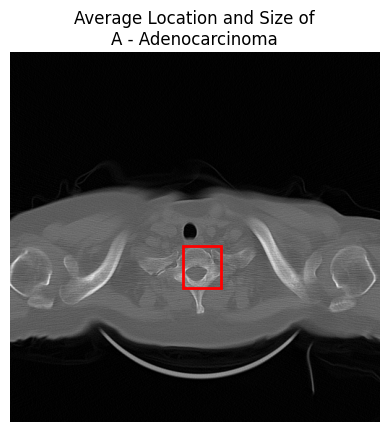

xmin_avg = 238.54, ymin_avg = 267.87, xmax_avg = 291.84, ymax_avg = 325.96
Bounding Box Dimensions (Width, Height): 53.3 x 58.09
------------------------------------------------------------------------



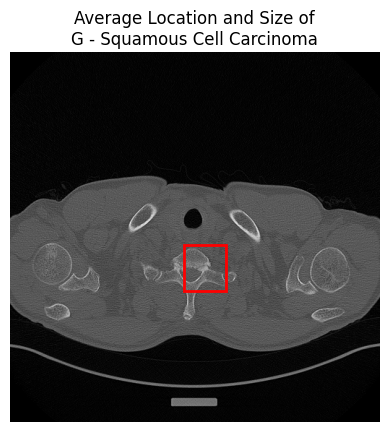

xmin_avg = 240.14, ymin_avg = 266.14, xmax_avg = 298.59, ymax_avg = 329.89
Bounding Box Dimensions (Width, Height): 58.45 x 63.75
------------------------------------------------------------------------



In [ ]:
# Sample file paths
sample_a = '/content/drive/MyDrive/METCS767/Final Project: Cancer Detection/Lung-PET-CT-Dx/Lung_Dx-A0002/04-25-2007-NA-ThoraxAThoraxRoutine Adult-34834/2.000000-ThoraxRoutine  8.0.0  B70f-62919/1-01.dcm'
sample_g = '/content/drive/MyDrive/METCS767/Final Project: Cancer Detection/Lung-PET-CT-Dx/Lung_Dx-G0060/01-21-2011-NA-PET01PTheadlung Adult-07418/10.000000-Thorax  1.0  B70f-17914/1-001.dcm'

samples_list = {
    "A - Adenocarcinoma": sample_a,
    "G - Squamous Cell Carcinoma": sample_g,
}

# Iterate through each sample
for label, sample in samples_list.items():
    dicom_data = pydicom.dcmread(sample)
    pixel_array = dicom_data.pixel_array

    # Create the plot
    fig, ax = plt.subplots()

    # Display the image
    ax.imshow(pixel_array, cmap='gray')
    ax.axis('off')  # Hide axes

    # Draw the bounding box frame (rectangles) using the average coordinates
    if label == "A - Adenocarcinoma":
        xmin, ymin, xmax, ymax = class_a_avg
    elif label == "G - Squamous Cell Carcinoma":
        xmin, ymin, xmax, ymax = class_g_avg

    # Add a rectangle frame to the image to indicate the bounding box
    rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

    # Calculate the width and height of the bounding box
    width = round(xmax - xmin, 2)
    height = round(ymax - ymin, 2)


    # Display the bounding box averages and dimensions
    avg_text = f"Averages: xmin: {xmin}, ymin: {ymin}, xmax: {xmax}, ymax: {ymax}\n"
    avg_text += f"Dimensions: width: {width}, height: {height}"

    # Add the title and display the image
    plt.title(f"Average Location and Size of\n{label}")

    # Show the image with the bounding box
    plt.show()

    # Print the averages and dimensions in the console as well
    print(f"xmin_avg = {xmin}, ymin_avg = {ymin}, xmax_avg = {xmax}, ymax_avg = {ymax}")
    print(f"Bounding Box Dimensions (Width, Height): {width} x {height}")
    print("------------------------"*3)
    print()

### Obtain Image data from DICOM files

#### Store images

##### Function

In [ ]:
%%time

def find_dcm_files(folder_path):
    """
    Recursively search for .dcm files in a folder and all its subfolders.
    """
    dcm_files = []
    try:
        # Loop through the contents of the folder
        for item in os.listdir(folder_path):
            item_path = os.path.join(folder_path, item)

            if os.path.isdir(item_path):
                # If it's a folder, recurse into it
                dcm_files.extend(find_dcm_files(item_path))  # Recursively look inside subfolders
            elif item.lower().endswith('.dcm'):
                # If it's a .dcm file, add it to the list
                dcm_files.append(item_path)
    except PermissionError:
        print(f"Permission denied: {folder_path}")
    except Exception as e:
        print(f"An error occurred: {e}")

    return dcm_files

def list_and_store_dcm_files(base_path):
    # Initialize empty lists for each class
    a_images = []
    g_images = []

    try:
        # Step 1: Get all folder names sorted alphabetically
        folders = sorted([folder for folder in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, folder))])

        # Step 2: Search for .dcm files in each folder (recursively)
        for idx, folder in enumerate(folders, 1):  # Enumerate with a counter starting from 1
            folder_path = os.path.join(base_path, folder)

            if folder.startswith('Lung_Dx-'):
                # Extract class prefix, assuming it follows the format 'Lung_Dx-<Class><Number>'
                class_prefix = folder.split('-')[1][0]  # Extracts the class letter (A, B, E, or G)

                # Check if the class is one of the valid ones (A, B, E, G)
                if class_prefix in ['A', 'G']:
                    # Recursively find all .dcm files in the folder and its subfolders
                    dcm_files = find_dcm_files(folder_path)

                    if dcm_files:
                        # Store the files in the appropriate class array based on the prefix
                        if class_prefix == 'A':
                            a_images.extend(dcm_files)
                        elif class_prefix == 'G':
                            g_images.extend(dcm_files)

            # Checkpoint every 25th folder processed
            if idx % 25 == 0:
                print(f"Checkpoint: Processed {idx} folders so far...")

    except FileNotFoundError:
        print(f"Path not found: {base_path}")
    except Exception as e:
        print(f"An error occurred: {e}")

    # Convert lists to NumPy arrays
    a_images = np.array(a_images)
    g_images = np.array(g_images)

    return a_images, g_images

CPU times: user 8 µs, sys: 0 ns, total: 8 µs
Wall time: 14.5 µs


##### Run function

In [ ]:
%%time

# Base path where the folders are stored
base_path = "/content/drive/MyDrive/METCS767/Final Project: Cancer Detection/Lung-PET-CT-Dx"

# Call the function to list and store .dcm files in arrays
a_images, g_images = list_and_store_dcm_files(base_path)

# Directory to store the files
output_dir = "/content/drive/MyDrive/METCS767/Final Project: Cancer Detection/stored_images_path"

# Create the directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# File paths for saving the lists
a_images_file = os.path.join(output_dir, "a_images.pkl")
g_images_file = os.path.join(output_dir, "g_images.pkl")

# Save the lists using pickle
with open(a_images_file, 'wb') as f:
    pickle.dump(a_images, f)

with open(g_images_file, 'wb') as f:
    pickle.dump(g_images, f)

print(f"a_images saved to {a_images_file}")
print(f"g_images saved to {g_images_file}")

Checkpoint: Processed 25 folders so far...
Checkpoint: Processed 50 folders so far...
Checkpoint: Processed 75 folders so far...
Checkpoint: Processed 100 folders so far...
Checkpoint: Processed 125 folders so far...
Checkpoint: Processed 150 folders so far...
Checkpoint: Processed 175 folders so far...
Checkpoint: Processed 200 folders so far...
Checkpoint: Processed 225 folders so far...
Checkpoint: Processed 250 folders so far...
Checkpoint: Processed 275 folders so far...
Checkpoint: Processed 300 folders so far...
Checkpoint: Processed 325 folders so far...
Checkpoint: Processed 350 folders so far...
a_images saved to /content/drive/MyDrive/METCS767/Final Project: Cancer Detection/stored_images_path/a_images.pkl
g_images saved to /content/drive/MyDrive/METCS767/Final Project: Cancer Detection/stored_images_path/g_images.pkl
CPU times: user 1.98 s, sys: 7.83 s, total: 9.81 s
Wall time: 4min 54s


In [ ]:
# Print the results (paths)
print(f"A class images (first 5):\n {a_images[0:5]}")
print(f"G class images (first 5):\n {g_images[0:5]}")

A class images (first 5):
 ['/content/drive/MyDrive/METCS767/Final Project: Cancer Detection/Lung-PET-CT-Dx/Lung_Dx-A0002/04-25-2007-NA-ThoraxAThoraxRoutine Adult-34834/3.000000-ThoraxRoutine  8.0.0  B40f-10983/1-01.dcm'
 '/content/drive/MyDrive/METCS767/Final Project: Cancer Detection/Lung-PET-CT-Dx/Lung_Dx-A0002/04-25-2007-NA-ThoraxAThoraxRoutine Adult-34834/3.000000-ThoraxRoutine  8.0.0  B40f-10983/1-02.dcm'
 '/content/drive/MyDrive/METCS767/Final Project: Cancer Detection/Lung-PET-CT-Dx/Lung_Dx-A0002/04-25-2007-NA-ThoraxAThoraxRoutine Adult-34834/3.000000-ThoraxRoutine  8.0.0  B40f-10983/1-03.dcm'
 '/content/drive/MyDrive/METCS767/Final Project: Cancer Detection/Lung-PET-CT-Dx/Lung_Dx-A0002/04-25-2007-NA-ThoraxAThoraxRoutine Adult-34834/3.000000-ThoraxRoutine  8.0.0  B40f-10983/1-07.dcm'
 '/content/drive/MyDrive/METCS767/Final Project: Cancer Detection/Lung-PET-CT-Dx/Lung_Dx-A0002/04-25-2007-NA-ThoraxAThoraxRoutine Adult-34834/3.000000-ThoraxRoutine  8.0.0  B40f-10983/1-10.dcm']
G 

In [ ]:
# Print the length of each object
print(f"Number of images in A class: {len(a_images)}")
print(f"Number of images in G class: {len(g_images)}")

Number of images in A class: 112427
Number of images in G class: 47148


## Data Preprocessing
- Read scans into pixel arrays
- Separate CT and PET scans

### Select X random samples

In [ ]:
# Current number of images in A class
a_images_count = len(a_images)

# Current number of images in G class
g_images_count = len(g_images)

# Target number of samples for both classes
# Set the target to 20,000
target_count = 20000

# Randomly sample 5,000 images from A class
if a_images_count > target_count:
    # Use NumPy to randomly sample indices
    sampled_indices = np.random.choice(a_images_count, target_count, replace=False)

    # Create a new array with the sampled images
    a_images_sampled = a_images[sampled_indices]

    print(f"Reduced A class images from {a_images_count} to {len(a_images_sampled)} samples.")
else:
    print(f"A class already has fewer ({a_images_count}) or equal samples than the target count ({target_count}).")

# Randomly sample 5,000 images from G class
if g_images_count > target_count:
    # Use NumPy to randomly sample indices
    sampled_indices = np.random.choice(g_images_count, target_count, replace=False)

    # Create a new array with the sampled images
    g_images_sampled = g_images[sampled_indices]

    print(f"Reduced G class images from {g_images_count} to {len(g_images_sampled)} samples.")
else:
    print(f"G class already has fewer ({g_images_count}) or equal samples than the target count ({target_count}).")

images_list = [a_images_sampled, g_images_sampled]

# Initialize a variable to store the sum of lengths
total_length = 0

# Iterate through each list in images_list and add its length to total_length
for i in images_list:
    total_length += len(i)

# Print the total length of all lists combined
print(f"Total amount of images: {total_length}")

Reduced A class images from 112427 to 20000 samples.
Reduced G class images from 47148 to 20000 samples.
Total amount of images: 40000


### Read images into pixel data

In [ ]:
# Function to read DICOM images and extract pixel arrays
def read_images_to_pixels(image_list):
    pixel_arrays = []
    for idx, image_path in enumerate(image_list, 1):  # `enumerate` starts at 1 to track the index
        try:
            # Read the DICOM file
            dicom_data = pydicom.dcmread(image_path)

            # Extract the pixel array from the DICOM file
            pixel_array = dicom_data.pixel_array

            # Add the pixel array to the list
            pixel_arrays.append(pixel_array)

            # Checkpoint every 500th image processed
            if idx % 2000 == 0:
                # print(f"Checkpoint: Processed {idx} images so far...")
                print(f"Checkpoint: Processed {(idx/total_length)*100}% of the images so far...")

        except Exception as e:
            print(f"Error processing {image_path}: {e}")  # Error handling without detailed message

    return pixel_arrays

In [ ]:
%%time

# Read DICOM images into pixel arrays for each image list
a_images_pixels = read_images_to_pixels(a_images_sampled)
g_images_pixels = read_images_to_pixels(g_images_sampled)

Checkpoint: Processed 5.0% of the images so far...
Checkpoint: Processed 10.0% of the images so far...
Checkpoint: Processed 15.0% of the images so far...
Checkpoint: Processed 20.0% of the images so far...
Checkpoint: Processed 25.0% of the images so far...
Checkpoint: Processed 30.0% of the images so far...
Checkpoint: Processed 35.0% of the images so far...
Checkpoint: Processed 40.0% of the images so far...
Checkpoint: Processed 45.0% of the images so far...
Checkpoint: Processed 50.0% of the images so far...
Checkpoint: Processed 5.0% of the images so far...
Checkpoint: Processed 10.0% of the images so far...
Checkpoint: Processed 15.0% of the images so far...
Checkpoint: Processed 20.0% of the images so far...
Checkpoint: Processed 25.0% of the images so far...
Checkpoint: Processed 30.0% of the images so far...
Checkpoint: Processed 35.0% of the images so far...
Checkpoint: Processed 40.0% of the images so far...
Checkpoint: Processed 45.0% of the images so far...
Checkpoint: Pr

In [ ]:
# Now, you have the pixel arrays for each of the image lists
# Example of accessing the pixel arrays:
print(f"First pixel array from a_images: {a_images_pixels[0]}\n")
print(f"First pixel array from g_images: {g_images_pixels[0]}")

First pixel array from a_images: [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

First pixel array from g_images: [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


### Separate CT and PET scans

In [ ]:
# Initialize counters
count_a_512x512 = 0
count_a_200x200 = 0
count_g_512x512 = 0
count_g_200x200 = 0

# Function to check dimensions and count for a specific class
def count_image_dimensions(images_list, class_name):
    global count_a_512x512, count_a_200x200, count_g_512x512, count_g_200x200
    for image in images_list:
        if image.shape[:2] == (512, 512):  # Check if image is 512x512
            if class_name == 'A':
                count_a_512x512 += 1
            elif class_name == 'G':
                count_g_512x512 += 1
        elif image.shape[:2] == (200, 200):  # Check if image is 200x200
            if class_name == 'A':
                count_a_200x200 += 1
            elif class_name == 'G':
                count_g_200x200 += 1

# Check dimensions for both classes
count_image_dimensions(a_images_pixels, 'A')
count_image_dimensions(g_images_pixels, 'G')

# Print the results
print(f"Class A - Total number of 512x512 images: {count_a_512x512}")
print(f"Class A - Total number of 200x200 images: {count_a_200x200}")
print(f"Class G - Total number of 512x512 images: {count_g_512x512}")
print(f"Class G - Total number of 200x200 images: {count_g_200x200}")

Class A - Total number of 512x512 images: 15838
Class A - Total number of 200x200 images: 4162
Class G - Total number of 512x512 images: 16095
Class G - Total number of 200x200 images: 3905


In [ ]:
# Initialize lists for separated images
a_images_512x512 = []
a_images_200x200 = []
g_images_512x512 = []
g_images_200x200 = []

# Function to separate images into different lists based on dimensions and class
def separate_images_by_dimensions(images_list, class_name):
    for image in images_list:
        if image.shape[:2] == (512, 512):  # Check if image is 512x512
            if class_name == 'A':
                a_images_512x512.append(image)
            elif class_name == 'G':
                g_images_512x512.append(image)
        elif image.shape[:2] == (200, 200):  # Check if image is 200x200
            if class_name == 'A':
                a_images_200x200.append(image)
            elif class_name == 'G':
                g_images_200x200.append(image)

# Separate images for both classes
separate_images_by_dimensions(a_images_pixels, 'A')
separate_images_by_dimensions(g_images_pixels, 'G')

# Print the counts
print(f"Class A - Total number of 512x512 images: {len(a_images_512x512)}")
print(f"Class A - Total number of 200x200 images: {len(a_images_200x200)}")
print(f"Class G - Total number of 512x512 images: {len(g_images_512x512)}")
print(f"Class G - Total number of 200x200 images: {len(g_images_200x200)}")

Class A - Total number of 512x512 images: 15838
Class A - Total number of 200x200 images: 4162
Class G - Total number of 512x512 images: 16095
Class G - Total number of 200x200 images: 3905


In [ ]:
%%time

# Directory path to save images
save_dir = '/content/drive/MyDrive/METCS767/Final Project: Cancer Detection/pixeled_images'

# Function to save images in pixel format
def save_images_as_pixels(image_list, class_name, dimensions):
    # Create a subdirectory for each class and dimension
    sub_dir = os.path.join(save_dir, f'{class_name}_{dimensions}')
    if not os.path.exists(sub_dir):
        os.makedirs(sub_dir)  # Create subdirectory if it doesn't exist

    for idx, img in enumerate(image_list):
        file_path = os.path.join(sub_dir, f'{class_name}_{dimensions}_{idx}.npy')
        try:
            # Save image as a numpy array
            np.save(file_path, img)
        except Exception as e:
            print(f"Error saving file {file_path}: {e}")

# Save images for each class and dimension
save_images_as_pixels(a_images_512x512, 'A', '512x512')
save_images_as_pixels(a_images_200x200, 'A', '200x200')
save_images_as_pixels(g_images_512x512, 'G', '512x512')
save_images_as_pixels(g_images_200x200, 'G', '200x200')

CPU times: user 8.43 s, sys: 16.7 s, total: 25.1 s
Wall time: 16min 28s


## CNN Training
- 20k images, 50-50 split between classes A and G
- 75% CT scans - 25% PET scans


Architecture:
- Input layer
- 4 convolution layers
- 4 max pooling layers
- 1 Flatten layer
- 1 Dense layer (512 neurons)
- Output layer (1 neuron, sigmoid activation)

Parameters:
- Loss function: binary cross entropy
- Metrics of interest: validation accuracy and loss
- Batch size: 64
- Optimizer: Adam
- Early stopping patience: 7 epochs

### Load Data from Drive

In [ ]:
# Base directory path where the folders are stored
pixel_images_dir = '/content/drive/MyDrive/METCS767/Final Project: Cancer Detection/pixeled_images'

# Subdirectory names (matching your structure)
subdirectories = {
    "A_512x512": [],
    "A_200x200": [],
    "G_512x512": [],
    "G_200x200": []
}

# Iterate over the subdirectories to load .npy files
for subdir, image_list in subdirectories.items():
    subdir_path = os.path.join(pixel_images_dir, subdir)

    if os.path.exists(subdir_path):
        print(f"Loading .npy files from '{subdir_path}'...")
        for item in os.listdir(subdir_path):
            item_path = os.path.join(subdir_path, item)
            if item.endswith(".npy"):  # Check if the file is a .npy file
                image_list.append(np.load(item_path))
    else:
        print(f"Directory '{subdir_path}' does not exist.")

# Assign loaded images to respective variables
a_images_512x512 = subdirectories["A_512x512"]
a_images_200x200 = subdirectories["A_200x200"]
g_images_512x512 = subdirectories["G_512x512"]
g_images_200x200 = subdirectories["G_200x200"]

# Print the results
print(f"Loaded {len(a_images_512x512)} images into 'a_images_512x512'")
print(f"Loaded {len(a_images_200x200)} images into 'a_images_200x200'")
print(f"Loaded {len(g_images_512x512)} images into 'g_images_512x512'")
print(f"Loaded {len(g_images_200x200)} images into 'g_images_200x200'")

Loading .npy files from '/content/drive/MyDrive/METCS767/Final Project: Cancer Detection/pixeled_images/A_512x512'...
Loading .npy files from '/content/drive/MyDrive/METCS767/Final Project: Cancer Detection/pixeled_images/A_200x200'...
Loading .npy files from '/content/drive/MyDrive/METCS767/Final Project: Cancer Detection/pixeled_images/G_512x512'...
Loading .npy files from '/content/drive/MyDrive/METCS767/Final Project: Cancer Detection/pixeled_images/G_200x200'...
Loaded 15838 images into 'a_images_512x512'
Loaded 4162 images into 'a_images_200x200'
Loaded 16095 images into 'g_images_512x512'
Loaded 3905 images into 'g_images_200x200'


### Baseline model
- 20k images, 50-50 split between classes
- Combination of CT and PET images
- Architecture:
    - Input layer
    - 4 convolution layers
    - 4 max pooling layers
    - 1 Dense layer (512 neurons)
    - Output layer (1 neuron, sigmoid activation)


#### Last preprocessing steps…

##### Resize images

In [ ]:
# Function to resize an image to 512x512
def resize_to_512x512(image):
    """
    Resize the given image to 512x512 dimensions.
    Args:
    - image: The input image (as a NumPy array).
    Returns:
    - Resized grayscale image (512x512).
    """
    resized_image = cv2.resize(image, (512, 512))  # Resize to 512x512
    # Ensure the image is grayscale (single channel)
    if len(resized_image.shape) == 3:  # If image has 3 channels (e.g., RGB)
        resized_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)
    return resized_image

# Function to check and resize all images in a list
def resize_images_to_512x512(images):
    """
    Resize all images in a list to 512x512 and ensure they are grayscale.
    Args:
    - images: List of images (NumPy arrays).
    Returns:
    - List of resized images (all 512x512 and grayscale).
    """
    resized_images = [resize_to_512x512(img) for img in images]
    return resized_images

# Apply resizing to all image lists
a_images_512x512_resized = resize_images_to_512x512(a_images_512x512)
g_images_512x512_resized = resize_images_to_512x512(g_images_512x512)
a_images_200x200_resized = resize_images_to_512x512(a_images_200x200)
g_images_200x200_resized = resize_images_to_512x512(g_images_200x200)

# Convert resized image lists to NumPy arrays
a_images_512x512 = np.array(a_images_512x512_resized)
g_images_512x512 = np.array(g_images_512x512_resized)
a_images_200x200 = np.array(a_images_200x200_resized)
g_images_200x200 = np.array(g_images_200x200_resized)

# Print shapes for verification
print(f"Class A - 512x512 images: {a_images_512x512.shape}")
print(f"Class G - 512x512 images: {g_images_512x512.shape}")
print(f"Class A - 200x200 images resized to 512x512: {a_images_200x200.shape}")
print(f"Class G - 200x200 images resized to 512x512: {g_images_200x200.shape}")

##### Test-Validation-Split

In [ ]:
# Assume a_images_200x200, g_images_200x200, a_images_512x512, and g_images_512x512 are lists of images
# Convert these lists into numpy arrays if they are not already
a_images_200x200 = np.array(a_images_200x200)
g_images_200x200 = np.array(g_images_200x200)
a_images_512x512 = np.array(a_images_512x512)
g_images_512x512 = np.array(g_images_512x512)

# Randomly select the required number of images from each class and size by selecting indices
a_indices_200x200 = np.random.choice(len(a_images_200x200), 2500, replace=False)  # Randomly select 2500 indices for class A (200x200)
g_indices_200x200 = np.random.choice(len(g_images_200x200), 2500, replace=False)  # Randomly select 2500 indices for class G (200x200)
a_indices_512x512 = np.random.choice(len(a_images_512x512), 7500, replace=False)  # Randomly select 7500 indices for class A (512x512)
g_indices_512x512 = np.random.choice(len(g_images_512x512), 7500, replace=False)  # Randomly select 7500 indices for class G (512x512)

# Select images based on the indices
X_a_200x200 = a_images_200x200[a_indices_200x200]
X_g_200x200 = g_images_200x200[g_indices_200x200]
X_a_512x512 = a_images_512x512[a_indices_512x512]
X_g_512x512 = g_images_512x512[g_indices_512x512]

# Concatenate all images into a single array
X = np.concatenate([X_a_200x200, X_g_200x200, X_a_512x512, X_g_512x512], axis=0)

# Create labels for the images
y = np.concatenate([
    np.array([0] * len(X_a_200x200)),  # Class A label (0)
    np.array([1] * len(X_g_200x200)),  # Class G label (1)
    np.array([0] * len(X_a_512x512)),  # Class A label (0)
    np.array([1] * len(X_g_512x512))   # Class G label (1)
])

# Step 1: Split into training and temp (validation + test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Step 2: Split temp into validation and test
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Output the shapes of the splits
print(f"Training data: {X_train.shape}, Training labels: {y_train.shape}")
print(f"Validation data: {X_val.shape}, Validation labels: {y_val.shape}")
print(f"Test data: {X_test.shape}, Test labels: {y_test.shape}")

In [ ]:
# Base directory for saving data
base_dir = "/content/drive/MyDrive/METCS767/Final Project: Cancer Detection/training_data"

# Create subdirectories for 'train', 'val', and 'test' data, as well as the respective class directories (0 and 1)
for subdir in ['train', 'val', 'test']:
    os.makedirs(os.path.join(base_dir, subdir, '0'), exist_ok=True)  # Class '0' (non-cancerous)
    os.makedirs(os.path.join(base_dir, subdir, '1'), exist_ok=True)  # Class '1' (cancerous)

# Function to save images as .npy files
def save_images_to_directory(X_data, y_data, subdir):
    """
    Saves images from X_data and corresponding labels from y_data to the appropriate directory.
    subdir is one of 'train', 'val', or 'test' representing the data split.
    """
    for i, (image, label) in enumerate(zip(X_data, y_data)):
        # Create the path for saving the image based on its label
        label_dir = os.path.join(base_dir, subdir, str(label))

        # Generate the filename
        image_filename = f"{subdir}_{i}.npy"
        image_path = os.path.join(label_dir, image_filename)

        # Save the image as a .npy file
        np.save(image_path, image)

# Save Training, Validation, and Test Data
save_images_to_directory(X_train, y_train, 'train')
save_images_to_directory(X_val, y_val, 'val')
save_images_to_directory(X_test, y_test, 'test')

##### Scale Values

In [ ]:
# Clip values to the valid range for grayscale images [0, 255]
X_train_clipped = np.clip(X_train, 0, 255)
X_val_clipped = np.clip(X_val, 0, 255)
X_test_clipped = np.clip(X_test, 0, 255)

# Convert the data to float32 for proper division and rescaling
X_train_scaled = X_train_clipped.astype(np.float32) / 255.0
X_val_scaled = X_val_clipped.astype(np.float32) / 255.0
X_test_scaled = X_test_clipped.astype(np.float32) / 255.0

print(f"Clipped and scaled training data range: min={X_train_scaled.min()}, max={X_train_scaled.max()}")
print(f"Clipped and scaled validation data range: min={X_val_scaled.min()}, max={X_val_scaled.max()}")
print(f"Clipped and scaled test data range: min={X_test_scaled.min()}, max={X_test_scaled.max()}")
print()

print(f"Clipped and scaled training data mean: {np.mean(X_train_scaled)}")
print(f"Clipped and scaled validation data mean: {np.mean(X_val_scaled)}")
print(f"Clipped and scaled test data mean: {np.mean(X_test_scaled)}")

Clipped and scaled training data range: min=0.0, max=1.0
Clipped and scaled validation data range: min=0.0, max=1.0
Clipped and scaled test data range: min=0.0, max=1.0

Clipped and scaled training data mean: 0.32048025727272034
Clipped and scaled validation data mean: 0.3189937472343445
Clipped and scaled test data mean: 0.3166112005710602


#### Model Architecture

In [ ]:
model = models.Sequential()
model.add(layers.InputLayer(input_shape=(512, 512, 1)))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 510, 510, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 255, 255, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 253, 253, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 126, 126, 64)      0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 124, 124, 128)     73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 62, 62, 128)       0

In [ ]:
# List of layers
for layer in model.layers:
  if isinstance(layer, (keras.layers.Conv2D, keras.layers.SeparableConv2D)):
    print(layer.name)

conv2d
conv2d_1
conv2d_2
conv2d_3


In [ ]:
# Compile model
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(),
              metrics=['acc'])

#### Training and Evaluation

In [ ]:
%%time

# Create history directory
history_dir = '/content/drive/MyDrive/METCS767/Final Project: Cancer Detection/history/'
os.makedirs(history_dir, exist_ok=True)

# EarlyStopping stops training if validation loss doesn't improve for 7 epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

# Checkpoint callback - save the best model so far based on validation loss
best_model_path = '/content/drive/MyDrive/METCS767/Final Project: Cancer Detection/models/best_model_baseline.keras'
checkpoint = ModelCheckpoint(best_model_path, save_best_only=True, monitor='val_loss', mode='min', verbose=1)

# Train the model with both callbacks
history_baseline = model.fit(X_train_scaled, y_train, epochs=30, batch_size=64,
                             validation_data=(X_val_scaled, y_val), callbacks=[checkpoint, early_stopping])

# Save the training history to the history directory
history_path = os.path.join(history_dir, 'history_baseline.pkl')
with open(history_path, 'wb') as f:
    pickle.dump(history_baseline.history, f)

Epoch 1/30
219/219 [==============================] - ETA: 0s - loss: 0.6279 - acc: 0.6536
Epoch 1: val_loss improved from inf to 0.49622, saving model to /content/drive/MyDrive/METCS767/Final Project: Cancer Detection/models/best_model_baseline.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


219/219 [==============================] - 1068s 5s/step - loss: 0.6279 - acc: 0.6536 - val_loss: 0.4962 - val_acc: 0.7627
Epoch 2/30
219/219 [==============================] - ETA: 0s - loss: 0.3185 - acc: 0.8594
Epoch 2: val_loss improved from 0.49622 to 0.27472, saving model to /content/drive/MyDrive/METCS767/Final Project: Cancer Detection/models/best_model_baseline.h5
219/219 [==============================] - 1038s 5s/step - loss: 0.3185 - acc: 0.8594 - val_loss: 0.2747 - val_acc: 0.8757
Epoch 3/30
219/219 [==============================] - ETA: 0s - loss: 0.1527 - acc: 0.9324
Epoch 3: val_loss improved from 0.27472 to 0.20505, saving model to /content/drive/MyDrive/METCS767/Final Project: Cancer Detection/models/best_model_baseline.h5
219/219 [==============================] - 1059s 5s/step - loss: 0.1527 - acc: 0.9324 - val_loss: 0.2050 - val_acc: 0.9230
Epoch 4/30
219/219 [==============================] - ETA: 0s - loss: 0.0870 - acc: 0.9635
Epoch 4: val_loss did not improve 

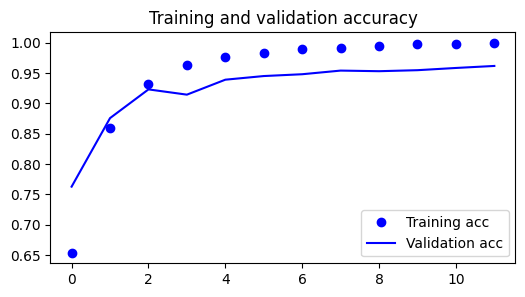

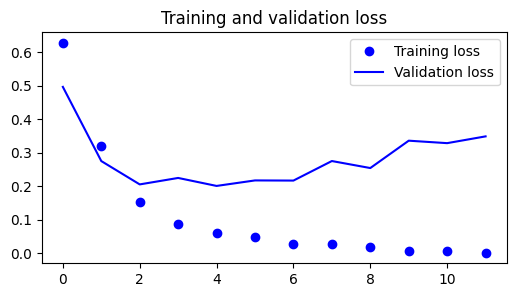

In [ ]:
# Validation Accuracy and Loss
acc = history_baseline.history['acc']
val_acc = history_baseline.history['val_acc']
loss = history_baseline.history['loss']
val_loss = history_baseline.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(6,3))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure(figsize=(6,3))

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Transfer Learning

- 20k images, 50-50 split between classes A and G
- 75% CT scans - 25% PET scans


Architecture:
- VGG16 convolutional base
- Flatten layer
- 1 Dense layer (512 neurons)
- Output layer (1 neuron, sigmoid activation)

Parameters:
- Loss function: binary cross entropy
- Metrics of interest: validation accuracy and loss
- Batch size: 64
- Optimizer: Adam
- Early stopping patience: 7 epochs

### VGG16
Link:
https://www.tensorflow.org/api_docs/python/tf/keras/applications/VGG16

#### Load data

In [ ]:
%%time

# Base directory for saved training data
base_dir = "/content/drive/MyDrive/METCS767/Final Project: Cancer Detection/training_data"

# Function to load images and labels from the directory with progress updates
def load_images_from_directory_with_progress(subdir):
    """
    Load images and labels from the directory with progress updates.
    Args:
        subdir (str): 'train', 'val', or 'test'
    Returns:
        X_data (list): List of images loaded as NumPy arrays.
        y_data (list): Corresponding labels for the images.
    """
    X_data = []
    y_data = []
    total_files = 0

    # Calculate total number of .npy files in the subdir
    for label in ['0', '1']:
        label_dir = os.path.join(base_dir, subdir, label)
        if os.path.exists(label_dir):
            total_files += len([f for f in os.listdir(label_dir) if f.endswith('.npy')])

    # Process files and provide progress updates
    processed_files = 0
    for label in ['0', '1']:  # '0' (non-cancerous), '1' (cancerous)
        label_dir = os.path.join(base_dir, subdir, label)
        if os.path.exists(label_dir):
            for file in os.listdir(label_dir):
                if file.endswith('.npy'):  # Only process .npy files
                    file_path = os.path.join(label_dir, file)

                    # Load the image
                    image = np.load(file_path)

                    # Append the image and its corresponding label
                    X_data.append(image)
                    y_data.append(int(label))

    return np.array(X_data), np.array(y_data)

# Load Training, Validation, and Test Data with progress updates
X_train, y_train = load_images_from_directory_with_progress('train')
X_val, y_val = load_images_from_directory_with_progress('val')
X_test, y_test = load_images_from_directory_with_progress('test')

# Print shapes to verify
print(f"Training Data: X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Validation Data: X_val: {X_val.shape}, y_val: {y_val.shape}")
print(f"Test Data: X_test: {X_test.shape}, y_test: {y_test.shape}")

Training Data: X_train: (17493, 512, 512), y_train: (17493,)
Validation Data: X_val: (3732, 512, 512), y_val: (3732,)
Test Data: X_test: (3750, 512, 512), y_test: (3750,)
CPU times: user 17.1 s, sys: 35.4 s, total: 52.5 s
Wall time: 29min 56s


In [ ]:
# Step 1: Select 14000 random samples from X_train and y_train
train_indices = np.random.choice(X_train.shape[0], 14000, replace=False)
X_train_selected = X_train[train_indices]
y_train_selected = y_train[train_indices]

# Step 2: Select 3000 random samples from X_val and y_val
val_indices = np.random.choice(X_val.shape[0], 3000, replace=False)
X_val_selected = X_val[val_indices]
y_val_selected = y_val[val_indices]

# Step 3: Select 3000 random samples from X_test and y_test
test_indices = np.random.choice(X_test.shape[0], 3000, replace=False)
X_test_selected = X_test[test_indices]
y_test_selected = y_test[test_indices]

# Step 4: Verify the new shapes
print(f"Training Data: X_train: {X_train_selected.shape}, y_train: {y_train_selected.shape}")
print(f"Validation Data: X_val: {X_val_selected.shape}, y_val: {y_val_selected.shape}")
print(f"Test Data: X_test: {X_test_selected.shape}, y_test: {y_test_selected.shape}")

Training Data: X_train: (14000, 512, 512), y_train: (14000,)
Validation Data: X_val: (3000, 512, 512), y_val: (3000,)
Test Data: X_test: (3000, 512, 512), y_test: (3000,)


#### Scale Values

In [ ]:
%%time

# Clip values to the valid range for grayscale images [0, 255]
X_train_clipped = np.clip(X_train_selected, 0, 255)
X_val_clipped = np.clip(X_val_selected, 0, 255)
X_test_clipped = np.clip(X_test_selected, 0, 255)

# Convert the data to float32 for proper division and rescaling
X_train_scaled = X_train_clipped.astype(np.float32) / 255.0
X_val_scaled = X_val_clipped.astype(np.float32) / 255.0
X_test_scaled = X_test_clipped.astype(np.float32) / 255.0

print(f"Clipped and scaled training data range: min={X_train_scaled.min()}, max={X_train_scaled.max()}")
print(f"Clipped and scaled validation data range: min={X_val_scaled.min()}, max={X_val_scaled.max()}")
print(f"Clipped and scaled test data range: min={X_test_scaled.min()}, max={X_test_scaled.max()}")
print()

print(f"Clipped and scaled training data mean: {np.mean(X_train_scaled)}")
print(f"Clipped and scaled validation data mean: {np.mean(X_val_scaled)}")
print(f"Clipped and scaled test data mean: {np.mean(X_test_scaled)}")

Clipped and scaled training data range: min=0.0, max=1.0
Clipped and scaled validation data range: min=0.0, max=1.0
Clipped and scaled test data range: min=0.0, max=1.0

Clipped and scaled training data mean: 0.32313165068626404
Clipped and scaled validation data mean: 0.32624924182891846
Clipped and scaled test data mean: 0.3168679475784302
CPU times: user 14.3 s, sys: 8.13 s, total: 22.4 s
Wall time: 22.3 s


#### Add RGB Channel

In [ ]:
%%time

# Ensure all images have 3 channels
def ensure_rgb(images):
    if len(images.shape) == 3:  # Grayscale input: (num_images, height, width)
        images = np.stack([images, images, images], axis=-1)  # Stack along the channel axis
    return images

X_train_rgb_scaled = ensure_rgb(X_train_scaled)  # Convert training data
X_val_rgb_scaled = ensure_rgb(X_val_scaled)      # Convert validation data
X_test_rgb_scaled = ensure_rgb(X_test_scaled)    # Convert test data

# Converting grayscale to RGB:
print(f"X_train_rgb shape: {X_train_rgb_scaled.shape}")
print(f"X_val_rgb shape: {X_val_rgb_scaled.shape}")
print(f"X_test_rgb shape: {X_test_rgb_scaled.shape}")

print("First observation shape: ", X_train_rgb_scaled[0].shape)

X_train_rgb shape: (14000, 512, 512, 3)
X_val_rgb shape: (3000, 512, 512, 3)
X_test_rgb shape: (3000, 512, 512, 3)
First observation shape:  (512, 512, 3)
CPU times: user 21.9 s, sys: 12.5 s, total: 34.4 s
Wall time: 34.2 s


#### Model Architecture

In [ ]:
# Load the pretrained VGG16 model
conv_base = VGG16(weights='imagenet',
                  include_top=False,          # Exclude fully connected layers
                  input_shape=(512, 512, 3))  # Input shape for the model

# Set model architecture
conv_base.trainable = False
vgg16 = models.Sequential()
vgg16.add(conv_base)
vgg16.add(layers.Flatten())
vgg16.add(layers.Dense(512, activation='relu'))
vgg16.add(layers.Dense(1, activation='sigmoid'))

# Summary of the model
vgg16.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 16, 16, 512)       14714688  
                                                                 
 flatten (Flatten)           (None, 131072)            0         
                                                                 
 dense (Dense)               (None, 512)               67109376  
                                                                 
 dense_1 (Dense)             (None, 1)                 513       
                                                                 
Total params: 81824577 (312.14 MB)
Trainable params: 67109889 (256.00 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 512, 512, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 512, 512, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 512, 512, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 256, 256, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 256, 256, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 256, 256, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 128, 128, 128)     0     

In [ ]:
# Compile model
vgg16.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(),
              metrics=['acc'])

#### Training and Evaluation

In [ ]:
%%time

# EarlyStopping callback: stops training if validation loss doesn't improve for 7 epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

# Checkpoint callback: save the best model based on validation loss
best_model_path = '/content/drive/MyDrive/METCS767/Final Project: Cancer Detection/models/best_model_vgg16.keras'
checkpoint = ModelCheckpoint(best_model_path, save_best_only=True, monitor='val_loss', mode='min', verbose=1)

# Train the model with both callbacks
history_vgg16 = vgg16.fit(X_train_rgb_scaled, y_train_selected, epochs=20, batch_size=64,
                          validation_data=(X_val_rgb_scaled, y_val_selected), callbacks=[checkpoint, early_stopping])

# Save the training history to the history directory
history_dir = '/content/drive/MyDrive/METCS767/Final Project: Cancer Detection/history/'
os.makedirs(history_dir, exist_ok=True)
history_path = os.path.join(history_dir, 'history_vgg16.pkl')
with open(history_path, 'wb') as f:
    pickle.dump(history_vgg16.history, f)

Epoch 1/20
219/219 [==============================] - ETA: 0s - loss: 1.2322 - acc: 0.7484
Epoch 1: val_loss improved from inf to 0.37517, saving model to /content/drive/MyDrive/METCS767/Final Project: Cancer Detection/models/best_model_vgg16.keras
219/219 [==============================] - 1681s 8s/step - loss: 1.2322 - acc: 0.7484 - val_loss: 0.3752 - val_acc: 0.8190
Epoch 2/20
219/219 [==============================] - ETA: 0s - loss: 0.2859 - acc: 0.8773
Epoch 2: val_loss improved from 0.37517 to 0.24387, saving model to /content/drive/MyDrive/METCS767/Final Project: Cancer Detection/models/best_model_vgg16.keras
219/219 [==============================] - 1723s 8s/step - loss: 0.2859 - acc: 0.8773 - val_loss: 0.2439 - val_acc: 0.8950
Epoch 3/20
219/219 [==============================] - ETA: 0s - loss: 0.1872 - acc: 0.9259
Epoch 3: val_loss improved from 0.24387 to 0.20700, saving model to /content/drive/MyDrive/METCS767/Final Project: Cancer Detection/models/best_model_vgg16.keras

NameError: name 'history_dir' is not defined

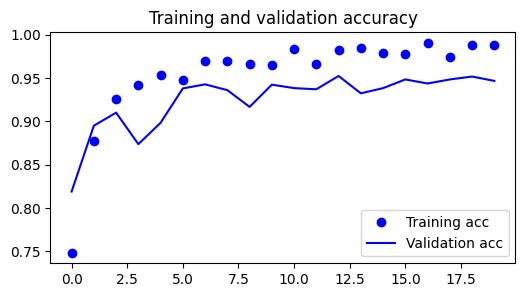

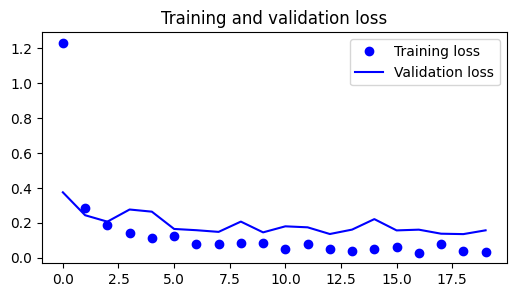

In [ ]:
# Validation Accuracy and Loss
acc = history_vgg16.history['acc']
val_acc = history_vgg16.history['val_acc']
loss = history_vgg16.history['loss']
val_loss = history_vgg16.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(6,3))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure(figsize=(6,3))

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Results
* Predictions on Test Data
* Comparison
* Conclusion

In [ ]:
# Load the history_baseline object
file_path = '/content/drive/MyDrive/METCS767/Final Project: Cancer Detection/history/history_baseline.pkl'
with open(file_path, 'rb') as file:
    history_baseline = pickle.load(file)

In [ ]:
%%time

baseline_test_loss, baseline_test_accuracy = model.evaluate(X_test_scaled, y_test_selected)
print(f"Test Loss: {baseline_test_loss:.4f}")
print(f"Test Accuracy: {baseline_test_accuracy:.4f}")

94/94 [==============================] - 43s 449ms/step - loss: 0.2025 - acc: 0.9460
Test Loss: 0.2025
Test Accuracy: 0.9460
CPU times: user 10min 26s, sys: 19min 37s, total: 30min 3s
Wall time: 46.2 s


In [ ]:
%%time

vgg16_test_loss, vgg16_test_accuracy = vgg16.evaluate(X_test_rgb_scaled, y_test_selected)
print(f"Test Loss: {vgg16_test_loss:.4f}")
print(f"Test Accuracy: {vgg16_test_accuracy:.4f}")

94/94 [==============================] - 291s 3s/step - loss: 0.1428 - acc: 0.9503
Test Loss: 0.1428
Test Accuracy: 0.9503
CPU times: user 3h 43min, sys: 1h 24min 32s, total: 5h 7min 32s
Wall time: 5min 2s


In [ ]:
# Round the test metrics to 4 decimal places
baseline_test_loss = round(baseline_test_loss, 4)
baseline_test_accuracy = round(baseline_test_accuracy, 4)
vgg16_test_loss = round(vgg16_test_loss, 4)
vgg16_test_accuracy = round(vgg16_test_accuracy, 4)

In [ ]:
# Extract the minimum val_loss index and corresponding val_acc for Baseline
baseline_index = np.argmin(history_baseline["val_loss"])
baseline_val_acc = round(history_baseline['val_acc'][baseline_index], 4)
baseline_val_loss = round(history_baseline['val_loss'][baseline_index], 4)

# Extract the minimum val_loss index and corresponding val_acc for VGG16
vgg16_index = np.argmin(history_vgg16.history['val_loss'])
vgg16_val_acc = round(history_vgg16.history['val_acc'][vgg16_index], 4)
vgg16_val_loss = round(history_vgg16.history['val_loss'][vgg16_index], 4)

# Create a DataFrame with rows and columns as specified
data = {
    'val acc': [baseline_val_acc, vgg16_val_acc],
    'val loss': [baseline_val_loss, vgg16_val_loss],
    'test acc': [baseline_test_accuracy, vgg16_test_accuracy],
    'test loss': [baseline_test_loss, vgg16_test_loss],
}

# Add rows for Baseline and VGG16
df = pd.DataFrame(data, index=['Baseline', 'VGG16'])
df.T

,Baseline,VGG16
val acc,0.9390,0.9517
val loss,0.2005,0.1356
test acc,0.9460,0.9503
test loss,0.2025,0.1428


In [ ]:
# Difference between models
df_t = df.T
df_t["Baseline"] - df_t["VGG16"]

,0
val acc,-0.0127
val loss,0.0649
test acc,-0.0043
test loss,0.0597
